In [1]:
import pandas as pd
import numpy as np
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from matplotlib import pyplot as plt

In [2]:
# Function to convert time series data to supervised learning format
def series_to_supervised(data, In=30, Out=1, dropnan=True):
    df = pd.DataFrame(data)
    columns = []
    for i in range(In, 0, -1):
        columns.append(df.shift(i))
    for i in range(0, Out):
        columns.append(df.shift(-i))
    agg = concat(columns, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# Function to split the data into train and test sets
def train_test_split(data, n):
    return data[:-n, :], data[-n:, :]

# Function to make a one-step forecast with Random Forest
def random_forest_forecast(train, test_x):
    train = np.asarray(train)
    train_x, train_y = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)  # Optimization parameters
    model.fit(train_x, train_y)
    yhat = model.predict([test_x])
    return yhat[0]

# Function for walk-forward validation
def walk_forward_validation(train, test):
    predictions = []
    history = [x for x in train]
    for i in range(len(test)):
        test_x, test_y = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, test_x)
        predictions.append(yhat)
        history.append(test[i])
        print(f'expected={test_y}, predicted={yhat}')
    
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions, history

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Forecasting the next 90 days
def forecast_next_days(data, n_days):
    predictions = []
    train, test = train_test_split(data, n_days)
    history = [x for x in train]
    for i in range(len(test)):
        test_x, test_y = test[i, :-1], test[i, -1]
        yhat = random_forest_forecast(history, test_x)
        predictions.append(yhat)
        history.append(test[i])
    return predictions

In [3]:
# Load the dataset
file_path = 'hanoi_quality.csv'  # Adjust the file path as needed
series_all = pd.read_csv(file_path, header=0, index_col=0, parse_dates=True)
series = series_all['pm25']
len_data = len(series)
n_in = 30
n_out = 1
ratio = 0.7


In [4]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    series_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    series_smoothed_interpolated = series_smoothed.interpolate()

    # Fill remaining NaN values
    series_smoothed_filled = series_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)
    
    return series_smoothed_filled

In [5]:
series_smoothed = smoothed(series)

C:\Users\21521\AppData\Local\Temp\ipykernel_12620\3312313537.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_smoothed_filled = series_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)


In [6]:
len(series_smoothed)

1920

In [7]:
# Convert the PM2.5 series to supervised learning
data = series_to_supervised(series_smoothed.values, In=n_in, Out=n_out)

In [8]:
len_test = len(data)-(int(len_data*ratio)-n_in)
train, test = train_test_split(data, len_test)

In [9]:
# Perform walk-forward validation on the test set
mae, y, yhat, history = walk_forward_validation(train, test)

expected=25.4, predicted=36.38521593200738
expected=21.2, predicted=23.820746722949885
expected=17.0, predicted=20.51335992326761
expected=16.2, predicted=16.557221626984123
expected=34.2, predicted=16.094617183540667
expected=50.6, predicted=40.15521027970054
expected=64.4, predicted=57.74428916083914
expected=75.8, predicted=69.49581812546477
expected=76.0, predicted=79.43401938339439
expected=67.8, predicted=78.65832034684993
expected=60.0, predicted=58.957254022644065
expected=54.0, predicted=54.3253113179821
expected=47.6, predicted=53.11246940912474
expected=43.8, predicted=44.61924377367365
expected=37.6, predicted=43.5002216782795
expected=33.6, predicted=34.505032192836154
expected=32.6, predicted=32.21106408411316
expected=39.2, predicted=33.622242438882395
expected=48.8, predicted=45.11545700278822
expected=55.4, predicted=53.39478497970913
expected=56.4, predicted=62.640685056715775
expected=56.0, predicted=57.18868042977287
expected=51.6, predicted=53.88322446637309
expect

In [10]:
yhat_series = pd.Series(yhat)
yhat_smoothed = smoothed(yhat_series)
yhat_smoothed = yhat_smoothed.to_numpy()

C:\Users\21521\AppData\Local\Temp\ipykernel_12620\3312313537.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series_smoothed_filled = series_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)


In [11]:
print('MAE:', mae)
# Calculate RMSE
rmse = mean_squared_error(y, yhat, squared=False)
print('RMSE:', rmse)
mape = mean_absolute_percentage_error(y, yhat)
print('MAPE:', mape)

MAE: 6.567879734934742
RMSE: 8.520425634053849
MAPE: 8.248679168156094


c:\Users\21521\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
# Fit the model on the entire dataset with optimization parameters
model = RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1)
model.fit(data[:, :-1], data[:, -1])
# Forecast the next 90 days
n_days = 90
forecast = forecast_next_days(data, n_days)

In [13]:
# forecast_series = pd.Series(forecast)
# forecast_smoothed = smoothed(forecast_series)
# forecast_smoothed = forecast_smoothed.to_numpy()

In [14]:
train = np.concatenate((train[0][0:30], np.array([x[30] for x in train]).T))

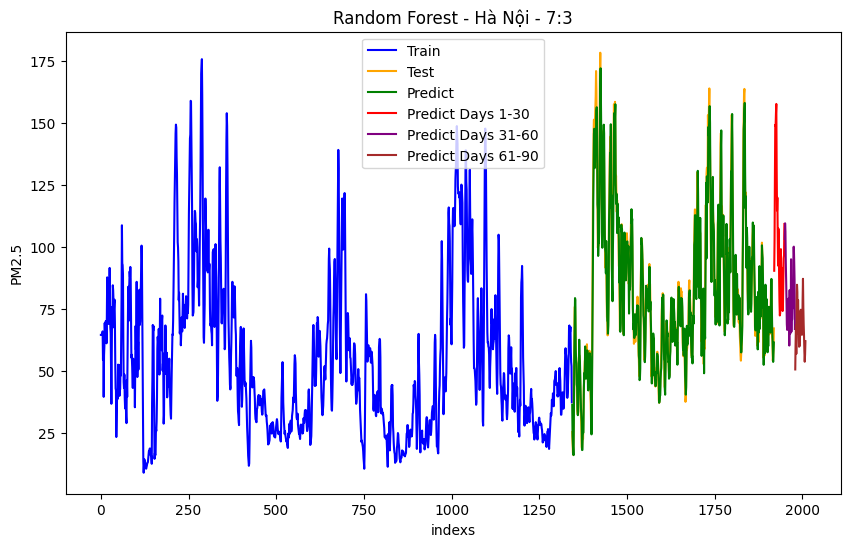

In [15]:
# Prepare data for plotting
train_index = range(len(train))
test_index = range(len(train), len(train) + len(test))
forecast_index = range(len(train) + len(test), len(train) + len(test) + n_days)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_index, train, color='blue', label='Train')
plt.plot(test_index, y, color='orange', label='Test')
plt.plot(test_index, yhat, color='green', label='Predict')
segment_size = 30
forecast_segments = [forecast[i*segment_size:(i+1)*segment_size] for i in range(3)]
colors = ['red', 'purple', 'brown']  # Màu cho từng phần
for i, segment in enumerate(forecast_segments):
    plt.plot(forecast_index[i*segment_size:(i+1)*segment_size], segment, color=colors[i], label=f'Predict Days {i*segment_size+1}-{(i+1)*segment_size}')

plt.xlabel('indexs')
plt.ylabel('PM2.5')
plt.legend()
plt.title('Random Forest - Hà Nội - 7:3')
plt.show()


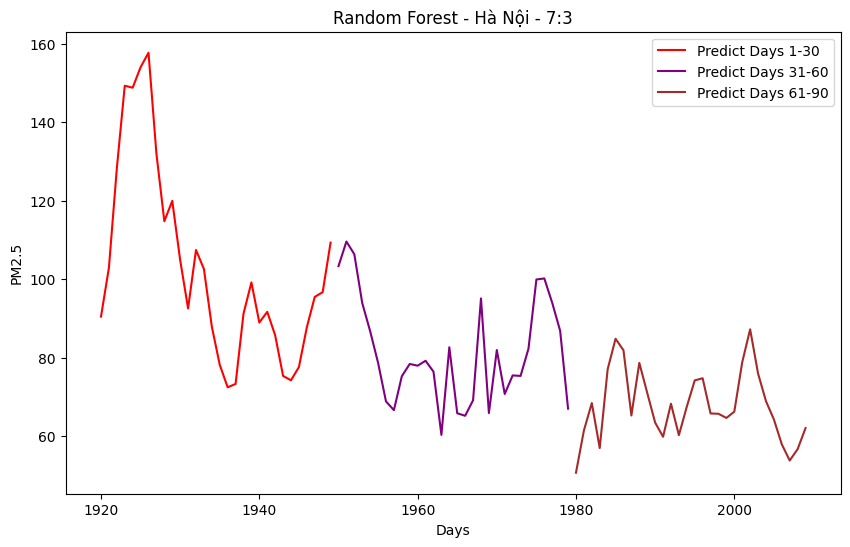

In [16]:
plt.figure(figsize=(10, 6))

# Split forecast into 3 segments
segment_size = 30
forecast_segments = [forecast[i*segment_size:(i+1)*segment_size] for i in range(3)]
colors = ['red', 'purple', 'brown']  # Màu cho từng phần
for i, segment in enumerate(forecast_segments):
    plt.plot(forecast_index[i*segment_size:(i+1)*segment_size], segment, color=colors[i], label=f'Predict Days {i*segment_size+1}-{(i+1)*segment_size}')

plt.xlabel('Days')
plt.ylabel('PM2.5')
plt.legend()
plt.title('Random Forest - Hà Nội - 7:3')
plt.show()
